In [32]:
# Dependencies 
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import os
import numpy as np


In [33]:
phdata = 'resources/pharmacydata.csv'
hdata = 'resources/heathdata.csv'
countypop = 'resources/countypopulation.csv'

In [34]:
phdf = pd.read_csv(phdata)
phdf = phdf.rename(columns={"STATE": "STATE ABV",
                            "STATE NAME": "STATE"})
phdf.head()

,PHARMACY_NAME,CITY,STATE,STATE ABV,ZIP,COUNTY
0,"CORPORATE PHARMACY SERVICES, INC.",GADSDEN,Alabama,AL,35901,ETOWAH
1,"NAPHCARE, INC",BIRMINGHAM,Alabama,AL,35216,JEFFERSON
2,BUY-RITE DRUGS,HARTSELLE,Alabama,AL,35640,MORGAN
3,TRANSDERMAL THERAPEUTICS INC,BIRMINGHAM,Alabama,AL,35209,JEFFERSON
4,SOLEO HEALTH INC,MOBILE,Alabama,AL,36606,MOBILE


In [35]:
hdf = pd.read_csv(hdata)
hdf = hdf.loc[:, ["CHSI_County_Name", "CHSI_State_Name", "ALE"]]
dataset = hdf.rename(columns={"CHSI_County_Name": "COUNTY",
                              "CHSI_State_Name": "STATE",
                              "ALE": "AVERAGE LIFE EXPECTANCY"})
dataset['COUNTY'] = dataset['COUNTY'].str.upper()
dataset.head()

,COUNTY,STATE,AVERAGE LIFE EXPECTANCY
0,AUTAUGA,Alabama,74.9
1,BALDWIN,Alabama,76.6
2,BARBOUR,Alabama,74.5
3,BIBB,Alabama,73.2
4,BLOUNT,Alabama,76.1


In [36]:
cpdf = pd.read_csv(countypop, encoding = "cp1252")
cpdf['CTYNAME'] = cpdf["CTYNAME"].apply( lambda x: x.replace(" County", ''))
cpdf.head()
cpdf = cpdf.rename(columns={"STNAME": "STATE",
                            "CTYNAME": "COUNTY",
                            "POPESTIMATE2017": "POPULATION"})
cpdf['COUNTY'] = cpdf['COUNTY'].str.upper()

In [37]:
cpdf.head()

,STATE,COUNTY,POPULATION
0,Alabama,AUTAUGA,55504
1,Alabama,BALDWIN,212628
2,Alabama,BARBOUR,25270
3,Alabama,BIBB,22668
4,Alabama,BLOUNT,58013


In [38]:
# Combine all of our datasets on relevant variables
m1 = cpdf.merge(phdf, how='left', on=['STATE', 'COUNTY'])
m2 = m1.merge(dataset, how='left', on=['STATE', 'COUNTY'])
texas = m2.loc[m2["STATE"] == "Texas",:]
texas = texas[["STATE", "COUNTY", "POPULATION", "PHARMACY_NAME", "AVERAGE LIFE EXPECTANCY"]]
texas.head()

# Count num of pharmacies in each county
pharmcount = texas[['COUNTY', 'STATE', 'PHARMACY_NAME']].\
    groupby(by=['COUNTY', 'STATE']).count()
pharmcount.head()

pharmcount = pharmcount.rename(columns={'PHARMACY_NAME': "# PHARMACIES"})
pharmcount.head()

,,# PHARMACIES
COUNTY,STATE,
ANDERSON,Texas,12
ANDREWS,Texas,5
ANGELINA,Texas,27
ARANSAS,Texas,6
ARCHER,Texas,1


In [39]:
# Primary statistics dataframe
ss1 = pharmcount.merge(cpdf,  how='left', on=['STATE', 'COUNTY'])
sumstats = ss1.merge(dataset,  how='left', on=['STATE', 'COUNTY'])
sumstats['PHARM CONCENTRATION (pop)'] = (sumstats['# PHARMACIES']/\
                                  sumstats['POPULATION'])*1000

In [40]:
# Method to go through df and classify each county
def classify(df):
    if df['POPULATION'] > 50000:
        return "Urban"
    elif df['POPULATION'] > 2500 and df['POPULATION'] < 50000:
        return "Urban Cluster"
    else:
        return "Rural"

In [41]:
sumstats['CLASSIFICATION'] = sumstats.apply(classify, axis=1)
sumstats.head()

,STATE,COUNTY,# PHARMACIES,POPULATION,AVERAGE LIFE EXPECTANCY,PHARM CONCENTRATION (pop),CLASSIFICATION
0,Texas,ANDERSON,12,57741,72.0,0.207825,Urban
1,Texas,ANDREWS,5,17722,75.5,0.282135,Urban Cluster
2,Texas,ANGELINA,27,87805,75.0,0.307500,Urban
3,Texas,ARANSAS,6,25572,75.2,0.234632,Urban Cluster
4,Texas,ARCHER,1,8809,75.8,0.113520,Urban Cluster


In [42]:
landarea = 'resources/txcountylandarea.csv'
txland = pd.read_csv(landarea, encoding= "cp1252")
txland.head()

,Rank,Name,Land Area (mi2),Population Density (mi2),Total Area (mi2)
0,1,Brewster,"6,183.70",1.5,"6,192.30"
1,2,Pecos,"4,763.90",3.3,"4,764.80"
2,3,Hudspeth,"4,571.00",0.8,"4,571.80"
3,4,Presidio,"3,855.20",2,"3,855.90"
4,5,Culberson,"3,812.80",0.6,"3,813.00"


In [43]:
cleaned = txland[["Name", "Land Area (mi2)"]]
cleaned = cleaned.rename(columns={"Name":"COUNTY",
                                  "Land Area (mi2)": "LAND AREA (mi^2)"})
cleaned["COUNTY"] = cleaned["COUNTY"].str.upper()
summary = sumstats.merge(cleaned, how='left', on="COUNTY")

In [44]:
# Creates new variable for pharmacy concentration based on land area of the county instead of population
summary['LAND AREA (mi^2)'] = summary['LAND AREA (mi^2)'].apply( lambda x:x.replace(",", ""))
summary['LAND AREA (mi^2)'] = summary['LAND AREA (mi^2)'].astype(float)
summary['# PHARMACIES'].astype(float)
summary['PHARM CONCENTRATION (land)'] = (summary['# PHARMACIES']/\
                                  summary['LAND AREA (mi^2)'])* 10

In [45]:
summary.head()

,STATE,COUNTY,# PHARMACIES,POPULATION,AVERAGE LIFE EXPECTANCY,PHARM CONCENTRATION (pop),CLASSIFICATION,LAND AREA (mi^2),PHARM CONCENTRATION (land)
0,Texas,ANDERSON,12,57741,72.0,0.207825,Urban,1062.6,0.112931
1,Texas,ANDREWS,5,17722,75.5,0.282135,Urban Cluster,1500.7,0.033318
2,Texas,ANGELINA,27,87805,75.0,0.307500,Urban,797.8,0.338431
3,Texas,ARANSAS,6,25572,75.2,0.234632,Urban Cluster,252.1,0.238001
4,Texas,ARCHER,1,8809,75.8,0.113520,Urban Cluster,903.1,0.011073


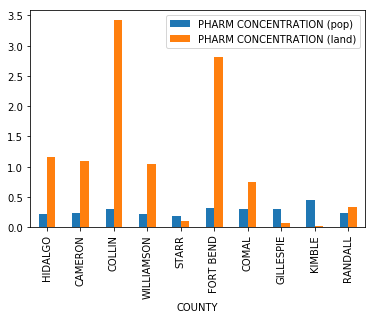

In [58]:
best_counties = summary.nlargest(10, 'AVERAGE LIFE EXPECTANCY')
#ax = best_counties.plot(x="COUNTY", y="AVERAGE LIFE EXPECTANCY", kind="bar")
#best_counties.plot(x="COUNTY", y="PHARM CONCENTRATION (pop)", kind="bar", ax=ax, color="C2")
#best_counties.plot(x="COUNTY", y="PHARM CONCENTRATION (land)", kind="bar", ax=ax, color="C3")

best_counties.plot(x="COUNTY", y=["PHARM CONCENTRATION (pop)","PHARM CONCENTRATION (land)"],
                  kind="bar")
plt.show()

In [18]:
# Creating a list of counties to parse into our findCoordinates method
counties = list(summary.apply(lambda row: row['COUNTY'], axis = 1))

In [19]:
# Using Google geocoding API to find lat/lon values for counties
#def findCoordinates(county):
  #  coords = ""
   # target_county = county + " county"
   # target_url = ('https://maps.googleapis.com/maps/api/geocode/json?'
    #'address={0}&key={1}').format(target_county, gkey)
   # response = requests.get(target_url).json()
   # results = response['results']
    
   # return{
        'COUNTY': county,
        'LAT': results[0]["geometry"]["location"]["lat"],
        'LNG': results[0]["geometry"]["location"]["lng"],
    }

In [20]:
savedcoords = [findCoordinates(e) for e in counties]

NameError: name 'gkey' is not defined

In [54]:
savedcoordsdf = pd.DataFrame(savedcoords)

In [50]:
savedcoordsdf.head()

,COUNTY,LAT,LNG
0,ANDERSON,34.552833,-82.648344
1,ANDREWS,32.342627,-102.713512
2,ANGELINA,31.270470,-94.645035
3,ARANSAS,28.076126,-96.963862
4,ARCHER,33.576151,-98.748117


In [9]:
final = summary.merge(savedcoordsdf, how='left', on="COUNTY")
final.head()

NameError: name 'summary' is not defined